# Загрузка модулей и библиотек

In [ ]:
!pip install statsmodels
!pip install scipy
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.1 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import welch
#from scipy.signal.windows import hanning
#from scipy.signal.windows import blackman


# Импортируем библиотеку statsmodels для создания модели ARIMA
import statsmodels.api as sm

# Импортируем саму модель ARIMA из библиотеки statsmodels
from statsmodels.tsa.arima.model import ARIMA




#from pmdarima.arima.utils import ndiffs
import matplotlib.dates as mdates
#from matplotlib.ticker import MaxNLocator, AutoMinorLocator
#from matplotlib.dates import HourLocator, MinuteLocator
#from matplotlib.ticker import AutoMinorLocator

Загрузка датафрейма "Канал 14"

In [9]:
from google.colab import files
import io

uploaded = files.upload()

# Проверяем, что файл был загружен
if len(uploaded) > 0:
    # Получаем имя файла (ключ в словаре uploaded)
    filename = list(uploaded.keys())[0]

    # Читаем CSV файл в DataFrame
    try:
        df_14 = pd.read_csv(io.BytesIO(uploaded[filename]))
    except Exception as e:
        print(f"Ошибка при чтении файла {filename}: {e}")
else:
    print("Файл не был загружен. Проверьте загрузку.")

print(df.head())

Saving df_consolidated.csv to df_consolidated.csv
         date   time       source_time  value_14  mode
0  2024-03-05  12:04  2024-03-05 12:04     332.0     1
1  2024-03-05  12:05  2024-03-05 12:05     334.0     1
2  2024-03-05  12:06  2024-03-05 12:06     295.0     1
3  2024-03-05  12:07  2024-03-05 12:07     160.0     1
4  2024-03-05  12:08  2024-03-05 12:08     167.0     1


# Загрузка "Канал 14"

In [2]:
from google.colab import files

uploaded = files.upload()
uploaded = files.upload()

Saving 14_2024-03-05_2024-09-05.xlsx to 14_2024-03-05_2024-09-05.xlsx


Saving 14_2024-09-05_2025-03-05.xlsx to 14_2024-09-05_2025-03-05.xlsx


In [3]:
# Читаем данные из первого листа файла Excel
df_14_1 = pd.read_excel('/content/14_2024-03-05_2024-09-05.xlsx', engine='openpyxl')
df_14_2 = pd.read_excel('/content/14_2024-09-05_2025-03-05.xlsx', engine='openpyxl')

df_14_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685201 entries, 0 to 685200
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   layer           685201 non-null  int64         
 1   archive_itemid  685201 non-null  int64         
 2   source_time     685201 non-null  datetime64[ns]
 3   value           685201 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 20.9 MB


In [4]:
# Объединение двух датафреймов
df = pd.concat([df_14_1, df_14_2], ignore_index=True)
df.info()


# Проверяем, существует ли колонка source_time
if 'source_time' in df.columns:
    # Преобразовываем source_time в объект datetime
    df['source_time'] = pd.to_datetime(df['source_time'])

    # Разделяем source_time на дату и время
    df['date'] = df['source_time'].dt.date
    df['time'] = df['source_time'].dt.time

    # Преобразуем time, чтобы отбросить секунды
    df['time'] = df['time'].apply(lambda t: t.replace(second=0))

# Показываем первые пять строк для проверки
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372177 entries, 0 to 1372176
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   layer           1372177 non-null  int64         
 1   archive_itemid  1372177 non-null  int64         
 2   source_time     1372177 non-null  datetime64[ns]
 3   value           1372177 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 41.9 MB
   layer  archive_itemid         source_time  value        date      time
0      1              14 2024-03-05 12:04:31    332  2024-03-05  12:04:00
1      1              14 2024-03-05 12:04:59    335  2024-03-05  12:04:00
2      1              14 2024-03-05 12:05:00    334  2024-03-05  12:05:00
3      1              14 2024-03-05 12:05:05    340  2024-03-05  12:05:00
4      1              14 2024-03-05 12:05:59    294  2024-03-05  12:05:00


In [5]:
# Группируем данные по дате и времени (минуты), выбираем строку с минимальной секундой
df_grouped = df.sort_values(by=['source_time']) \
               .groupby(['date', 'time'], as_index=False) \
               .first()

# Показываем результат
print(df_grouped.head())
print(len(df_grouped))
df_grouped.info()
print('=====================================')


# Определяем минимальную и максимальную даты
min_date = df_grouped['date'].min()
max_date = df_grouped['date'].max()

# Генерируем все возможные даты между min_date и max_date
dates = pd.date_range(min_date, max_date, freq='D')

# Генерируем все возможные минуты в течение дня
minutes = pd.date_range('00:00', '23:59', freq='min').time

# Создаем DataFrame с полными датами и минутами
df_base = pd.DataFrame({
    'date': np.repeat(dates, len(minutes)),
    'time': np.tile(minutes, len(dates))
})

# Преобразуем time в формат HH:MM
df_base['time'] = df_base['time'].astype(str).str.slice(0, 5)

df_base.info()
print(len(df_base))
print(min_date)
print(max_date)
print('=====================================')





# Преобразуем столбец 'date' в df_base в формат datetime64[ns]
df_base['date'] = pd.to_datetime(df_base['date'])

# Преобразуем столбец 'date' в df_grouped в формат datetime64[ns]
df_grouped['date'] = pd.to_datetime(df_grouped['date'])

# Приводим столбец 'time' в df_base к формату 'HH:MM'
df_base['time'] = df_base['time'].str.slice(0, 5)

# Приводим столбец 'time' в df_grouped к формату 'HH:MM'
df_grouped['time'] = df_grouped['time'].astype(str).str.slice(0, 5)

# Объединяем df_base с df_grouped по дате и времени
result_df = df_base.merge(df_grouped, how='left', on=['date', 'time'])

# Заполняем пропущенные значения value, перенося последние известные значения вперед
#result_df['value'] = result_df['value'].fillna(method='ffill')

# Линейная интерполяция для заполнения пропущенных значений value
result_df['value'] = result_df['value'].interpolate()

# Показываем результат
print(result_df.head())
result_df.info()
print(len(result_df))
print('=====================================')




#  Удаляем NaN
result_df_no_na = result_df.dropna(subset=['value'])
# Показываем результат
print(result_df_no_na.head())
result_df_no_na.info()
print(len(result_df_no_na))

         date      time  layer  archive_itemid         source_time  value
0  2024-03-05  12:04:00      1              14 2024-03-05 12:04:31    332
1  2024-03-05  12:05:00      1              14 2024-03-05 12:05:00    334
2  2024-03-05  12:06:00      1              14 2024-03-05 12:06:00    295
3  2024-03-05  12:07:00      1              14 2024-03-05 12:07:00    160
4  2024-03-05  12:08:00      1              14 2024-03-05 12:08:00    167
427440
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427440 entries, 0 to 427439
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            427440 non-null  object        
 1   time            427440 non-null  object        
 2   layer           427440 non-null  int64         
 3   archive_itemid  427440 non-null  int64         
 4   source_time     427440 non-null  datetime64[ns]
 5   value           427440 non-null  int64         
dtypes: datetim

In [6]:
df_14 = result_df_no_na.copy()
df_14 = df_14.rename(columns={'value': 'value_14'})
df_14.head()

,date,time,layer,archive_itemid,source_time,value_14
724,2024-03-05,12:04,1.0,14.0,2024-03-05 12:04:31,332.0
725,2024-03-05,12:05,1.0,14.0,2024-03-05 12:05:00,334.0
726,2024-03-05,12:06,1.0,14.0,2024-03-05 12:06:00,295.0
727,2024-03-05,12:07,1.0,14.0,2024-03-05 12:07:00,160.0
728,2024-03-05,12:08,1.0,14.0,2024-03-05 12:08:00,167.0


# Загрузка "Канал 10"

In [7]:
from google.colab import files

uploaded = files.upload()
uploaded = files.upload()

Saving 10_2024-03-05_2024-09-05.xlsx to 10_2024-03-05_2024-09-05.xlsx


Saving 10_2024-09-05_2025-03-05.xlsx to 10_2024-09-05_2025-03-05.xlsx


In [8]:
# Читаем данные из первого листа файла Excel
df_10_1 = pd.read_excel('/content/10_2024-03-05_2024-09-05.xlsx', engine='openpyxl')
df_10_2 = pd.read_excel('/content/10_2024-09-05_2025-03-05.xlsx', engine='openpyxl')

df_10_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768392 entries, 0 to 768391
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   layer           768392 non-null  int64         
 1   archive_itemid  768392 non-null  int64         
 2   source_time     768392 non-null  datetime64[ns]
 3   value           768392 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 23.4 MB


In [9]:
df_10_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735167 entries, 0 to 735166
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   layer           735167 non-null  int64         
 1   archive_itemid  735167 non-null  int64         
 2   source_time     735167 non-null  datetime64[ns]
 3   value           735167 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 22.4 MB


In [10]:
# Объединение двух датафреймов
df = pd.concat([df_10_1, df_10_2], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503559 entries, 0 to 1503558
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   layer           1503559 non-null  int64         
 1   archive_itemid  1503559 non-null  int64         
 2   source_time     1503559 non-null  datetime64[ns]
 3   value           1503559 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 45.9 MB


In [11]:
# Проверяем, существует ли колонка source_time
if 'source_time' in df.columns:
    # Преобразовываем source_time в объект datetime
    df['source_time'] = pd.to_datetime(df['source_time'])

    # Разделяем source_time на дату и время
    df['date'] = df['source_time'].dt.date
    df['time'] = df['source_time'].dt.time

    # Преобразуем time, чтобы отбросить секунды
    df['time'] = df['time'].apply(lambda t: t.replace(second=0))

# Показываем первые пять строк для проверки
print(df.head())

   layer  archive_itemid         source_time      value        date      time
0      1              10 2024-03-05 12:04:25  15.058824  2024-03-05  12:04:00
1      1              10 2024-03-05 12:04:33  14.911765  2024-03-05  12:04:00
2      1              10 2024-03-05 12:04:59  14.970589  2024-03-05  12:04:00
3      1              10 2024-03-05 12:05:00  14.941176  2024-03-05  12:05:00
4      1              10 2024-03-05 12:05:30  15.058824  2024-03-05  12:05:00


In [12]:
# Группируем данные по дате и времени (минуты), выбираем строку с минимальной секундой
df_grouped = df.sort_values(by=['source_time']) \
               .groupby(['date', 'time'], as_index=False) \
               .first()

# Показываем результат
print(df_grouped.head())
print(len(df_grouped))
df_grouped.info()

         date      time  layer  archive_itemid         source_time      value
0  2024-03-05  12:04:00      1              10 2024-03-05 12:04:25  15.058824
1  2024-03-05  12:05:00      1              10 2024-03-05 12:05:00  14.941176
2  2024-03-05  12:06:00      1              10 2024-03-05 12:06:00  10.735294
3  2024-03-05  12:07:00      1              10 2024-03-05 12:07:00   3.029412
4  2024-03-05  12:08:00      1              10 2024-03-05 12:08:00   2.970588
496058
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496058 entries, 0 to 496057
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            496058 non-null  object        
 1   time            496058 non-null  object        
 2   layer           496058 non-null  int64         
 3   archive_itemid  496058 non-null  int64         
 4   source_time     496058 non-null  datetime64[ns]
 5   value           496058 non-null  float6

In [13]:
# Определяем минимальную и максимальную даты
min_date = df_grouped['date'].min()
max_date = df_grouped['date'].max()

# Генерируем все возможные даты между min_date и max_date
dates = pd.date_range(min_date, max_date, freq='D')

# Генерируем все возможные минуты в течение дня
minutes = pd.date_range('00:00', '23:59', freq='min').time

# Создаем DataFrame с полными датами и минутами
df_base = pd.DataFrame({
    'date': np.repeat(dates, len(minutes)),
    'time': np.tile(minutes, len(dates))
})

# Преобразуем time в формат HH:MM
df_base['time'] = df_base['time'].astype(str).str.slice(0, 5)

df_base.info()
print(len(df_base))
print(min_date)
print(max_date)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527040 entries, 0 to 527039
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    527040 non-null  datetime64[ns]
 1   time    527040 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 8.0+ MB
527040
2024-03-05
2025-03-05


In [14]:
# Преобразуем столбец 'date' в df_base в формат datetime64[ns]
df_base['date'] = pd.to_datetime(df_base['date'])

# Преобразуем столбец 'date' в df_grouped в формат datetime64[ns]
df_grouped['date'] = pd.to_datetime(df_grouped['date'])

# Приводим столбец 'time' в df_base к формату 'HH:MM'
df_base['time'] = df_base['time'].str.slice(0, 5)

# Приводим столбец 'time' в df_grouped к формату 'HH:MM'
df_grouped['time'] = df_grouped['time'].astype(str).str.slice(0, 5)

# Объединяем df_base с df_grouped по дате и времени
result_df = df_base.merge(df_grouped, how='left', on=['date', 'time'])

# Заполняем пропущенные значения value, перенося последние известные значения вперед
#result_df['value'] = result_df['value'].fillna(method='ffill')

# Линейная интерполяция для заполнения пропущенных значений value
result_df['value'] = result_df['value'].interpolate()

# Показываем результат
print(result_df.head())
result_df.info()
print(len(result_df))

        date   time  layer  archive_itemid source_time  value
0 2024-03-05  00:00    NaN             NaN         NaT    NaN
1 2024-03-05  00:01    NaN             NaN         NaT    NaN
2 2024-03-05  00:02    NaN             NaN         NaT    NaN
3 2024-03-05  00:03    NaN             NaN         NaT    NaN
4 2024-03-05  00:04    NaN             NaN         NaT    NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527040 entries, 0 to 527039
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            527040 non-null  datetime64[ns]
 1   time            527040 non-null  object        
 2   layer           496058 non-null  float64       
 3   archive_itemid  496058 non-null  float64       
 4   source_time     496058 non-null  datetime64[ns]
 5   value           526316 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(1)
memory usage: 24.1+ MB
527040


In [15]:
#  Удаляем NaN
result_df_no_na = result_df.dropna(subset=['value'])
# Показываем результат
print(result_df_no_na.head())
result_df_no_na.info()
print(len(result_df_no_na))

          date   time  layer  archive_itemid         source_time      value
724 2024-03-05  12:04    1.0            10.0 2024-03-05 12:04:25  15.058824
725 2024-03-05  12:05    1.0            10.0 2024-03-05 12:05:00  14.941176
726 2024-03-05  12:06    1.0            10.0 2024-03-05 12:06:00  10.735294
727 2024-03-05  12:07    1.0            10.0 2024-03-05 12:07:00   3.029412
728 2024-03-05  12:08    1.0            10.0 2024-03-05 12:08:00   2.970588
<class 'pandas.core.frame.DataFrame'>
Index: 526316 entries, 724 to 527039
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            526316 non-null  datetime64[ns]
 1   time            526316 non-null  object        
 2   layer           496058 non-null  float64       
 3   archive_itemid  496058 non-null  float64       
 4   source_time     496058 non-null  datetime64[ns]
 5   value           526316 non-null  float64       
dtypes: datet

In [ ]:
df_10 = result_df_no_na.rename(columns={'value': 'value_10'})



try:
    df_14['source_time'] = pd.to_datetime(df_14['source_time'])
except ValueError as e:
    print(f"Не удалось преобразовать столбец 'source_time' в df_14: {e}")
    # Обработай ошибку.  Возможно, в столбце есть некорректные значения.
    exit()

try:
    df_10['source_time'] = pd.to_datetime(df_10['source_time'])
except ValueError as e:
    print(f"Не удалось преобразовать столбец 'source_time' в df_10: {e}")
    # Обработай ошибку.
    exit()


# Объединяем датафреймы по колонке 'source_time'
df_14 = pd.merge(df_14, df_10[['source_time', 'value_10']], on='source_time', how='left')

# Заполнение NaN предыдущим или следующим значением:
df_14 = df_14.fillna(method='ffill')
df_14 = df_14.fillna(method='bfill')

df_14.head(10)

In [45]:
df_14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427453 entries, 0 to 427452
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         427453 non-null  object        
 1   time         427453 non-null  object        
 2   source_time  427453 non-null  datetime64[ns]
 3   value_14     427453 non-null  float64       
 4   mode         427453 non-null  int64         
 5   value_16     427453 non-null  float64       
 6   value_10     427453 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 22.8+ MB


# Загрузка "Канал 16"

In [24]:
from google.colab import files

uploaded = files.upload()
uploaded = files.upload()

Saving 16_2024-03-05_2024-09-05.xlsx to 16_2024-03-05_2024-09-05.xlsx


Saving 16_2024-09-05_2025-03-05.xlsx to 16_2024-09-05_2025-03-05.xlsx


In [25]:
# Читаем данные из первого листа файла Excel
df_16_1 = pd.read_excel('/content/16_2024-03-05_2024-09-05.xlsx', engine='openpyxl')
df_16_2 = pd.read_excel('/content/16_2024-09-05_2025-03-05.xlsx', engine='openpyxl')

df_16_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540951 entries, 0 to 540950
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   layer           540951 non-null  int64         
 1   archive_itemid  540951 non-null  int64         
 2   source_time     540951 non-null  datetime64[ns]
 3   value           540951 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 16.5 MB


In [26]:
df_16_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 741041 entries, 0 to 741040
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   layer           741041 non-null  int64         
 1   archive_itemid  741041 non-null  int64         
 2   source_time     741041 non-null  datetime64[ns]
 3   value           741041 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 22.6 MB


In [27]:
# Объединение двух датафреймов
df = pd.concat([df_16_1, df_16_2], ignore_index=True)
df.info()


# Проверяем, существует ли колонка source_time
if 'source_time' in df.columns:
    # Преобразовываем source_time в объект datetime
    df['source_time'] = pd.to_datetime(df['source_time'])

    # Разделяем source_time на дату и время
    df['date'] = df['source_time'].dt.date
    df['time'] = df['source_time'].dt.time

    # Преобразуем time, чтобы отбросить секунды
    df['time'] = df['time'].apply(lambda t: t.replace(second=0))

# Показываем первые пять строк для проверки
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1281992 entries, 0 to 1281991
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   layer           1281992 non-null  int64         
 1   archive_itemid  1281992 non-null  int64         
 2   source_time     1281992 non-null  datetime64[ns]
 3   value           1281992 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 39.1 MB
   layer  archive_itemid         source_time      value        date      time
0      1              16 2024-03-05 12:04:59  35.625000  2024-03-05  12:04:00
1      1              16 2024-03-05 12:05:00  35.568180  2024-03-05  12:05:00
2      1              16 2024-03-05 12:05:00  35.625000  2024-03-05  12:05:00
3      1              16 2024-03-05 12:05:59  24.375000  2024-03-05  12:05:00
4      1              16 2024-03-05 12:06:00  24.261364  2024-03-05  12:06:00


In [28]:
# Группируем данные по дате и времени (минуты), выбираем строку с минимальной секундой
df_grouped = df.sort_values(by=['source_time']) \
               .groupby(['date', 'time'], as_index=False) \
               .first()

# Показываем результат
print(df_grouped.head())
print(len(df_grouped))
df_grouped.info()

         date      time  layer  archive_itemid         source_time      value
0  2024-03-05  12:04:00      1              16 2024-03-05 12:04:59  35.625000
1  2024-03-05  12:05:00      1              16 2024-03-05 12:05:00  35.568180
2  2024-03-05  12:06:00      1              16 2024-03-05 12:06:00  24.261364
3  2024-03-05  12:07:00      1              16 2024-03-05 12:07:01   5.909091
4  2024-03-05  12:08:00      1              16 2024-03-05 12:08:01   7.045455
415923
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415923 entries, 0 to 415922
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            415923 non-null  object        
 1   time            415923 non-null  object        
 2   layer           415923 non-null  int64         
 3   archive_itemid  415923 non-null  int64         
 4   source_time     415923 non-null  datetime64[ns]
 5   value           415923 non-null  float6

In [29]:
# Определяем минимальную и максимальную даты
min_date = df_grouped['date'].min()
max_date = df_grouped['date'].max()

# Генерируем все возможные даты между min_date и max_date
dates = pd.date_range(min_date, max_date, freq='D')

# Генерируем все возможные минуты в течение дня
minutes = pd.date_range('00:00', '23:59', freq='min').time

# Создаем DataFrame с полными датами и минутами
df_base = pd.DataFrame({
    'date': np.repeat(dates, len(minutes)),
    'time': np.tile(minutes, len(dates))
})

# Преобразуем time в формат HH:MM
df_base['time'] = df_base['time'].astype(str).str.slice(0, 5)

df_base.info()
print(len(df_base))
print(min_date)
print(max_date)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527040 entries, 0 to 527039
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    527040 non-null  datetime64[ns]
 1   time    527040 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 8.0+ MB
527040
2024-03-05
2025-03-05


In [30]:
# Преобразуем столбец 'date' в df_base в формат datetime64[ns]
df_base['date'] = pd.to_datetime(df_base['date'])

# Преобразуем столбец 'date' в df_grouped в формат datetime64[ns]
df_grouped['date'] = pd.to_datetime(df_grouped['date'])

# Приводим столбец 'time' в df_base к формату 'HH:MM'
df_base['time'] = df_base['time'].str.slice(0, 5)

# Приводим столбец 'time' в df_grouped к формату 'HH:MM'
df_grouped['time'] = df_grouped['time'].astype(str).str.slice(0, 5)

# Объединяем df_base с df_grouped по дате и времени
result_df = df_base.merge(df_grouped, how='left', on=['date', 'time'])

# Заполняем пропущенные значения value, перенося последние известные значения вперед
#result_df['value'] = result_df['value'].fillna(method='ffill')

# Линейная интерполяция для заполнения пропущенных значений value
result_df['value'] = result_df['value'].interpolate()

# Показываем результат
print(result_df.head())
result_df.info()
print(len(result_df))

        date   time  layer  archive_itemid source_time  value
0 2024-03-05  00:00    NaN             NaN         NaT    NaN
1 2024-03-05  00:01    NaN             NaN         NaT    NaN
2 2024-03-05  00:02    NaN             NaN         NaT    NaN
3 2024-03-05  00:03    NaN             NaN         NaT    NaN
4 2024-03-05  00:04    NaN             NaN         NaT    NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527040 entries, 0 to 527039
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            527040 non-null  datetime64[ns]
 1   time            527040 non-null  object        
 2   layer           415923 non-null  float64       
 3   archive_itemid  415923 non-null  float64       
 4   source_time     415923 non-null  datetime64[ns]
 5   value           526316 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(1)
memory usage: 24.1+ MB
527040


In [31]:
#  Удаляем NaN
result_df_no_na = result_df.dropna(subset=['value'])
# Показываем результат
print(result_df_no_na.head())
result_df_no_na.info()
print(len(result_df_no_na))

          date   time  layer  archive_itemid         source_time      value
724 2024-03-05  12:04    1.0            16.0 2024-03-05 12:04:59  35.625000
725 2024-03-05  12:05    1.0            16.0 2024-03-05 12:05:00  35.568180
726 2024-03-05  12:06    1.0            16.0 2024-03-05 12:06:00  24.261364
727 2024-03-05  12:07    1.0            16.0 2024-03-05 12:07:01   5.909091
728 2024-03-05  12:08    1.0            16.0 2024-03-05 12:08:01   7.045455
<class 'pandas.core.frame.DataFrame'>
Index: 526316 entries, 724 to 527039
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            526316 non-null  datetime64[ns]
 1   time            526316 non-null  object        
 2   layer           415923 non-null  float64       
 3   archive_itemid  415923 non-null  float64       
 4   source_time     415923 non-null  datetime64[ns]
 5   value           526316 non-null  float64       
dtypes: datet

In [33]:
df_16 = result_df_no_na.rename(columns={'value': 'value_16'})



try:
    df_14['source_time'] = pd.to_datetime(df_14['source_time'])
except ValueError as e:
    print(f"Не удалось преобразовать столбец 'source_time' в df_14: {e}")
    # Обработай ошибку.  Возможно, в столбце есть некорректные значения.
    exit()

try:
    df_16['source_time'] = pd.to_datetime(df_16['source_time'])
except ValueError as e:
    print(f"Не удалось преобразовать столбец 'source_time' в df_16: {e}")
    # Обработай ошибку.
    exit()


# Объединяем датафреймы по колонке 'source_time'
df_14 = pd.merge(df_14, df_16[['source_time', 'value_16']], on='source_time', how='left')

# Заполнение NaN предыдущим или следующим значением:
df_14 = df_14.fillna(method='ffill')
df_14 = df_14.fillna(method='bfill')

df_14.head(10)

<ipython-input-33-c262586cae60>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_14 = df_14.fillna(method='ffill')
<ipython-input-33-c262586cae60>:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_14 = df_14.fillna(method='bfill')


,date,time,source_time,value_14,mode,value_16
0,2024-03-05,12:04,2024-03-05 12:04:00,332.0,1,35.568180
1,2024-03-05,12:05,2024-03-05 12:05:00,334.0,1,35.568180
2,2024-03-05,12:06,2024-03-05 12:06:00,295.0,1,24.261364
3,2024-03-05,12:07,2024-03-05 12:07:00,160.0,1,24.261364
4,2024-03-05,12:08,2024-03-05 12:08:00,167.0,1,24.261364
5,2024-03-05,12:09,2024-03-05 12:09:00,168.0,1,24.261364
6,2024-03-05,12:10,2024-03-05 12:10:00,168.0,1,7.045455
7,2024-03-05,12:11,2024-03-05 12:11:00,170.0,1,7.045455
8,2024-03-05,12:12,2024-03-05 12:12:00,171.0,1,7.045455
9,2024-03-05,12:13,2024-03-05 12:13:00,170.0,1,7.102273


In [46]:
df_14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427453 entries, 0 to 427452
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         427453 non-null  object        
 1   time         427453 non-null  object        
 2   source_time  427453 non-null  datetime64[ns]
 3   value_14     427453 non-null  float64       
 4   mode         427453 non-null  int64         
 5   value_16     427453 non-null  float64       
 6   value_10     427453 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 22.8+ MB


# Загрузка "Канал 23"

In [47]:
from google.colab import files

uploaded = files.upload()
uploaded = files.upload()

Saving 23_2024-03-05_2024-09-05.xlsx to 23_2024-03-05_2024-09-05.xlsx


Saving 23_2024-09-05_2025-03-05.xlsx to 23_2024-09-05_2025-03-05.xlsx


In [49]:
# Читаем данные из первого листа файла Excel
df_23_1 = pd.read_excel('/content/23_2024-03-05_2024-09-05.xlsx', engine='openpyxl')
df_23_2 = pd.read_excel('/content/23_2024-09-05_2025-03-05.xlsx', engine='openpyxl')

df_23_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630543 entries, 0 to 630542
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   layer           630543 non-null  int64         
 1   archive_itemid  630543 non-null  int64         
 2   source_time     630543 non-null  datetime64[ns]
 3   value           630543 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 19.2 MB


In [50]:
df_23_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603287 entries, 0 to 603286
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   layer           603287 non-null  int64         
 1   archive_itemid  603287 non-null  int64         
 2   source_time     603287 non-null  datetime64[ns]
 3   value           603287 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 18.4 MB


In [51]:
# Объединение двух датафреймов
df = pd.concat([df_23_1, df_23_2], ignore_index=True)
df.info()


# Проверяем, существует ли колонка source_time
if 'source_time' in df.columns:
    # Преобразовываем source_time в объект datetime
    df['source_time'] = pd.to_datetime(df['source_time'])

    # Разделяем source_time на дату и время
    df['date'] = df['source_time'].dt.date
    df['time'] = df['source_time'].dt.time

    # Преобразуем time, чтобы отбросить секунды
    df['time'] = df['time'].apply(lambda t: t.replace(second=0))

# Показываем первые пять строк для проверки
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1233830 entries, 0 to 1233829
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   layer           1233830 non-null  int64         
 1   archive_itemid  1233830 non-null  int64         
 2   source_time     1233830 non-null  datetime64[ns]
 3   value           1233830 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 37.7 MB
   layer  archive_itemid         source_time      value        date      time
0      1              23 2024-03-05 12:04:47  38.730000  2024-03-05  12:04:00
1      1              23 2024-03-05 12:04:59  38.674999  2024-03-05  12:04:00
2      1              23 2024-03-05 12:05:00  38.689999  2024-03-05  12:05:00
3      1              23 2024-03-05 12:05:40  38.740002  2024-03-05  12:05:00
4      1              23 2024-03-05 12:05:53  38.590000  2024-03-05  12:05:00


In [52]:
# Группируем данные по дате и времени (минуты), выбираем строку с минимальной секундой
df_grouped = df.sort_values(by=['source_time']) \
               .groupby(['date', 'time'], as_index=False) \
               .first()

# Показываем результат
print(df_grouped.head())
print(len(df_grouped))
df_grouped.info()
print('=====================================')


# Определяем минимальную и максимальную даты
min_date = df_grouped['date'].min()
max_date = df_grouped['date'].max()

# Генерируем все возможные даты между min_date и max_date
dates = pd.date_range(min_date, max_date, freq='D')

# Генерируем все возможные минуты в течение дня
minutes = pd.date_range('00:00', '23:59', freq='min').time

# Создаем DataFrame с полными датами и минутами
df_base = pd.DataFrame({
    'date': np.repeat(dates, len(minutes)),
    'time': np.tile(minutes, len(dates))
})

# Преобразуем time в формат HH:MM
df_base['time'] = df_base['time'].astype(str).str.slice(0, 5)

df_base.info()
print(len(df_base))
print(min_date)
print(max_date)
print('=====================================')





# Преобразуем столбец 'date' в df_base в формат datetime64[ns]
df_base['date'] = pd.to_datetime(df_base['date'])

# Преобразуем столбец 'date' в df_grouped в формат datetime64[ns]
df_grouped['date'] = pd.to_datetime(df_grouped['date'])

# Приводим столбец 'time' в df_base к формату 'HH:MM'
df_base['time'] = df_base['time'].str.slice(0, 5)

# Приводим столбец 'time' в df_grouped к формату 'HH:MM'
df_grouped['time'] = df_grouped['time'].astype(str).str.slice(0, 5)

# Объединяем df_base с df_grouped по дате и времени
result_df = df_base.merge(df_grouped, how='left', on=['date', 'time'])

# Заполняем пропущенные значения value, перенося последние известные значения вперед
#result_df['value'] = result_df['value'].fillna(method='ffill')

# Линейная интерполяция для заполнения пропущенных значений value
result_df['value'] = result_df['value'].interpolate()

# Показываем результат
print(result_df.head())
result_df.info()
print(len(result_df))
print('=====================================')




#  Удаляем NaN
result_df_no_na = result_df.dropna(subset=['value'])
# Показываем результат
print(result_df_no_na.head())
result_df_no_na.info()
print(len(result_df_no_na))


         date      time  layer  archive_itemid         source_time      value
0  2024-03-05  12:04:00      1              23 2024-03-05 12:04:47  38.730000
1  2024-03-05  12:05:00      1              23 2024-03-05 12:05:00  38.689999
2  2024-03-05  12:06:00      1              23 2024-03-05 12:06:00  38.720001
3  2024-03-05  12:07:00      1              23 2024-03-05 12:07:00  38.584999
4  2024-03-05  12:08:00      1              23 2024-03-05 12:08:00  38.674999
320004
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320004 entries, 0 to 320003
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            320004 non-null  object        
 1   time            320004 non-null  object        
 2   layer           320004 non-null  int64         
 3   archive_itemid  320004 non-null  int64         
 4   source_time     320004 non-null  datetime64[ns]
 5   value           320004 non-null  float6

In [53]:
df_23 = result_df_no_na.rename(columns={'value': 'value_23'})



try:
    df_14['source_time'] = pd.to_datetime(df_14['source_time'])
except ValueError as e:
    print(f"Не удалось преобразовать столбец 'source_time' в df_14: {e}")
    # Обработай ошибку.  Возможно, в столбце есть некорректные значения.
    exit()

try:
    df_23['source_time'] = pd.to_datetime(df_23['source_time'])
except ValueError as e:
    print(f"Не удалось преобразовать столбец 'source_time' в df_23: {e}")
    # Обработай ошибку.
    exit()


# Объединяем датафреймы по колонке 'source_time'
df_14 = pd.merge(df_14, df_23[['source_time', 'value_23']], on='source_time', how='left')

# Заполнение NaN предыдущим или следующим значением:
df_14 = df_14.fillna(method='ffill')
df_14 = df_14.fillna(method='bfill')

df_14.head(10)

<ipython-input-53-9e49f62dbea6>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_14 = df_14.fillna(method='ffill')
<ipython-input-53-9e49f62dbea6>:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_14 = df_14.fillna(method='bfill')


,date,time,source_time,value_14,mode,value_16,value_10,value_23
0,2024-03-05,12:04,2024-03-05 12:04:00,332.0,1,35.568180,14.941176,38.689999
1,2024-03-05,12:05,2024-03-05 12:05:00,334.0,1,35.568180,14.941176,38.689999
2,2024-03-05,12:06,2024-03-05 12:06:00,295.0,1,24.261364,10.735294,38.720001
3,2024-03-05,12:07,2024-03-05 12:07:00,160.0,1,24.261364,3.029412,38.584999
4,2024-03-05,12:08,2024-03-05 12:08:00,167.0,1,24.261364,2.970588,38.674999
5,2024-03-05,12:09,2024-03-05 12:09:00,168.0,1,24.261364,2.970588,38.709999
6,2024-03-05,12:10,2024-03-05 12:10:00,168.0,1,7.045455,2.941176,38.764999
7,2024-03-05,12:11,2024-03-05 12:11:00,170.0,1,7.045455,3.000000,38.555000
8,2024-03-05,12:12,2024-03-05 12:12:00,171.0,1,7.045455,3.000000,38.615002
9,2024-03-05,12:13,2024-03-05 12:13:00,170.0,1,7.102273,2.941176,38.639999


# Загрузка "Канал 24"

In [54]:
from google.colab import files

uploaded = files.upload()
uploaded = files.upload()

Saving 24_2024-03-05_2024-09-05.xlsx to 24_2024-03-05_2024-09-05.xlsx


Saving 24_2024-09-05_2025-03-05.xlsx to 24_2024-09-05_2025-03-05.xlsx


In [55]:
# Читаем данные из первого листа файла Excel
df_24_1 = pd.read_excel('/content/24_2024-03-05_2024-09-05.xlsx', engine='openpyxl')
df_24_2 = pd.read_excel('/content/24_2024-09-05_2025-03-05.xlsx', engine='openpyxl')

df_24_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655733 entries, 0 to 655732
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   layer           655733 non-null  int64         
 1   archive_itemid  655733 non-null  int64         
 2   source_time     655733 non-null  datetime64[ns]
 3   value           655733 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 20.0 MB


In [56]:
# Объединение двух датафреймов
df = pd.concat([df_24_1, df_24_2], ignore_index=True)
df.info()


# Проверяем, существует ли колонка source_time
if 'source_time' in df.columns:
    # Преобразовываем source_time в объект datetime
    df['source_time'] = pd.to_datetime(df['source_time'])

    # Разделяем source_time на дату и время
    df['date'] = df['source_time'].dt.date
    df['time'] = df['source_time'].dt.time

    # Преобразуем time, чтобы отбросить секунды
    df['time'] = df['time'].apply(lambda t: t.replace(second=0))

# Показываем первые пять строк для проверки
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234765 entries, 0 to 1234764
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   layer           1234765 non-null  int64         
 1   archive_itemid  1234765 non-null  int64         
 2   source_time     1234765 non-null  datetime64[ns]
 3   value           1234765 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 37.7 MB
   layer  archive_itemid         source_time      value        date      time
0      1              24 2024-03-05 12:04:21  39.445000  2024-03-05  12:04:00
1      1              24 2024-03-05 12:04:47  39.639999  2024-03-05  12:04:00
2      1              24 2024-03-05 12:04:59  39.535000  2024-03-05  12:04:00
3      1              24 2024-03-05 12:05:00  39.549999  2024-03-05  12:05:00
4      1              24 2024-03-05 12:05:29  39.639999  2024-03-05  12:05:00


In [57]:
# Группируем данные по дате и времени (минуты), выбираем строку с минимальной секундой
df_grouped = df.sort_values(by=['source_time']) \
               .groupby(['date', 'time'], as_index=False) \
               .first()

# Показываем результат
print(df_grouped.head())
print(len(df_grouped))
df_grouped.info()
print('=====================================')


# Определяем минимальную и максимальную даты
min_date = df_grouped['date'].min()
max_date = df_grouped['date'].max()

# Генерируем все возможные даты между min_date и max_date
dates = pd.date_range(min_date, max_date, freq='D')

# Генерируем все возможные минуты в течение дня
minutes = pd.date_range('00:00', '23:59', freq='min').time

# Создаем DataFrame с полными датами и минутами
df_base = pd.DataFrame({
    'date': np.repeat(dates, len(minutes)),
    'time': np.tile(minutes, len(dates))
})

# Преобразуем time в формат HH:MM
df_base['time'] = df_base['time'].astype(str).str.slice(0, 5)

df_base.info()
print(len(df_base))
print(min_date)
print(max_date)
print('=====================================')





# Преобразуем столбец 'date' в df_base в формат datetime64[ns]
df_base['date'] = pd.to_datetime(df_base['date'])

# Преобразуем столбец 'date' в df_grouped в формат datetime64[ns]
df_grouped['date'] = pd.to_datetime(df_grouped['date'])

# Приводим столбец 'time' в df_base к формату 'HH:MM'
df_base['time'] = df_base['time'].str.slice(0, 5)

# Приводим столбец 'time' в df_grouped к формату 'HH:MM'
df_grouped['time'] = df_grouped['time'].astype(str).str.slice(0, 5)

# Объединяем df_base с df_grouped по дате и времени
result_df = df_base.merge(df_grouped, how='left', on=['date', 'time'])

# Заполняем пропущенные значения value, перенося последние известные значения вперед
#result_df['value'] = result_df['value'].fillna(method='ffill')

# Линейная интерполяция для заполнения пропущенных значений value
result_df['value'] = result_df['value'].interpolate()

# Показываем результат
print(result_df.head())
result_df.info()
print(len(result_df))
print('=====================================')




#  Удаляем NaN
result_df_no_na = result_df.dropna(subset=['value'])
# Показываем результат
print(result_df_no_na.head())
result_df_no_na.info()
print(len(result_df_no_na))

         date      time  layer  archive_itemid         source_time      value
0  2024-03-05  12:04:00      1              24 2024-03-05 12:04:21  39.445000
1  2024-03-05  12:05:00      1              24 2024-03-05 12:05:00  39.549999
2  2024-03-05  12:06:00      1              24 2024-03-05 12:06:01  39.470001
3  2024-03-05  12:07:00      1              24 2024-03-05 12:07:00  38.924999
4  2024-03-05  12:08:00      1              24 2024-03-05 12:08:01  38.730000
320546
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320546 entries, 0 to 320545
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            320546 non-null  object        
 1   time            320546 non-null  object        
 2   layer           320546 non-null  int64         
 3   archive_itemid  320546 non-null  int64         
 4   source_time     320546 non-null  datetime64[ns]
 5   value           320546 non-null  float6

In [58]:
df_24 = result_df_no_na.rename(columns={'value': 'value_24'})



try:
    df_14['source_time'] = pd.to_datetime(df_14['source_time'])
except ValueError as e:
    print(f"Не удалось преобразовать столбец 'source_time' в df_14: {e}")
    # Обработай ошибку.  Возможно, в столбце есть некорректные значения.
    exit()

try:
    df_24['source_time'] = pd.to_datetime(df_24['source_time'])
except ValueError as e:
    print(f"Не удалось преобразовать столбец 'source_time' в df_24: {e}")
    # Обработай ошибку.
    exit()


# Объединяем датафреймы по колонке 'source_time'
df_14 = pd.merge(df_14, df_24[['source_time', 'value_24']], on='source_time', how='left')

# Заполнение NaN предыдущим или следующим значением:
df_14 = df_14.fillna(method='ffill')
df_14 = df_14.fillna(method='bfill')

df_14.head(10)

<ipython-input-58-af220c86bdea>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_14 = df_14.fillna(method='ffill')
<ipython-input-58-af220c86bdea>:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_14 = df_14.fillna(method='bfill')


,date,time,source_time,value_14,mode,value_16,value_10,value_23,value_24
0,2024-03-05,12:04,2024-03-05 12:04:00,332.0,1,35.568180,14.941176,38.689999,39.549999
1,2024-03-05,12:05,2024-03-05 12:05:00,334.0,1,35.568180,14.941176,38.689999,39.549999
2,2024-03-05,12:06,2024-03-05 12:06:00,295.0,1,24.261364,10.735294,38.720001,39.549999
3,2024-03-05,12:07,2024-03-05 12:07:00,160.0,1,24.261364,3.029412,38.584999,38.924999
4,2024-03-05,12:08,2024-03-05 12:08:00,167.0,1,24.261364,2.970588,38.674999,38.924999
5,2024-03-05,12:09,2024-03-05 12:09:00,168.0,1,24.261364,2.970588,38.709999,38.465000
6,2024-03-05,12:10,2024-03-05 12:10:00,168.0,1,7.045455,2.941176,38.764999,38.465000
7,2024-03-05,12:11,2024-03-05 12:11:00,170.0,1,7.045455,3.000000,38.555000,38.845001
8,2024-03-05,12:12,2024-03-05 12:12:00,171.0,1,7.045455,3.000000,38.615002,38.830002
9,2024-03-05,12:13,2024-03-05 12:13:00,170.0,1,7.102273,2.941176,38.639999,38.919998


# Загрузка "Канал 26"

In [59]:
from google.colab import files

uploaded = files.upload()
uploaded = files.upload()

Saving 26_2024-03-05_2024-09-05.xlsx to 26_2024-03-05_2024-09-05.xlsx


Saving 26_2024-09-05_2025-03-05.xlsx to 26_2024-09-05_2025-03-05.xlsx


In [60]:
# Читаем данные из первого листа файла Excel
df_24_1 = pd.read_excel('/content/26_2024-03-05_2024-09-05.xlsx', engine='openpyxl')
df_24_2 = pd.read_excel('/content/26_2024-09-05_2025-03-05.xlsx', engine='openpyxl')

df_24_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433792 entries, 0 to 433791
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   layer           433792 non-null  int64         
 1   archive_itemid  433792 non-null  int64         
 2   source_time     433792 non-null  datetime64[ns]
 3   value           433792 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 13.2 MB


In [61]:
# Объединение двух датафреймов
df = pd.concat([df_24_1, df_24_2], ignore_index=True)
df.info()


# Проверяем, существует ли колонка source_time
if 'source_time' in df.columns:
    # Преобразовываем source_time в объект datetime
    df['source_time'] = pd.to_datetime(df['source_time'])

    # Разделяем source_time на дату и время
    df['date'] = df['source_time'].dt.date
    df['time'] = df['source_time'].dt.time

    # Преобразуем time, чтобы отбросить секунды
    df['time'] = df['time'].apply(lambda t: t.replace(second=0))

# Показываем первые пять строк для проверки
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922757 entries, 0 to 922756
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   layer           922757 non-null  int64         
 1   archive_itemid  922757 non-null  int64         
 2   source_time     922757 non-null  datetime64[ns]
 3   value           922757 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 28.2 MB
   layer  archive_itemid         source_time  value        date      time
0      1              26 2024-03-05 12:04:59  90969  2024-03-05  12:04:00
1      1              26 2024-03-05 12:05:00  90994  2024-03-05  12:05:00
2      1              26 2024-03-05 12:05:21      0  2024-03-05  12:05:00
3      1              26 2024-03-05 12:05:58  92374  2024-03-05  12:05:00
4      1              26 2024-03-05 12:06:00  92392  2024-03-05  12:06:00


In [62]:
# Группируем данные по дате и времени (минуты), выбираем строку с минимальной секундой
df_grouped = df.sort_values(by=['source_time']) \
               .groupby(['date', 'time'], as_index=False) \
               .first()

# Показываем результат
print(df_grouped.head())
print(len(df_grouped))
df_grouped.info()
print('=====================================')


# Определяем минимальную и максимальную даты
min_date = df_grouped['date'].min()
max_date = df_grouped['date'].max()

# Генерируем все возможные даты между min_date и max_date
dates = pd.date_range(min_date, max_date, freq='D')

# Генерируем все возможные минуты в течение дня
minutes = pd.date_range('00:00', '23:59', freq='min').time

# Создаем DataFrame с полными датами и минутами
df_base = pd.DataFrame({
    'date': np.repeat(dates, len(minutes)),
    'time': np.tile(minutes, len(dates))
})

# Преобразуем time в формат HH:MM
df_base['time'] = df_base['time'].astype(str).str.slice(0, 5)

df_base.info()
print(len(df_base))
print(min_date)
print(max_date)
print('=====================================')





# Преобразуем столбец 'date' в df_base в формат datetime64[ns]
df_base['date'] = pd.to_datetime(df_base['date'])

# Преобразуем столбец 'date' в df_grouped в формат datetime64[ns]
df_grouped['date'] = pd.to_datetime(df_grouped['date'])

# Приводим столбец 'time' в df_base к формату 'HH:MM'
df_base['time'] = df_base['time'].str.slice(0, 5)

# Приводим столбец 'time' в df_grouped к формату 'HH:MM'
df_grouped['time'] = df_grouped['time'].astype(str).str.slice(0, 5)

# Объединяем df_base с df_grouped по дате и времени
result_df = df_base.merge(df_grouped, how='left', on=['date', 'time'])

# Заполняем пропущенные значения value, перенося последние известные значения вперед
#result_df['value'] = result_df['value'].fillna(method='ffill')

# Линейная интерполяция для заполнения пропущенных значений value
result_df['value'] = result_df['value'].interpolate()

# Показываем результат
print(result_df.head())
result_df.info()
print(len(result_df))
print('=====================================')




#  Удаляем NaN
result_df_no_na = result_df.dropna(subset=['value'])
# Показываем результат
print(result_df_no_na.head())
result_df_no_na.info()
print(len(result_df_no_na))

         date      time  layer  archive_itemid         source_time  value
0  2024-03-05  12:04:00      1              26 2024-03-05 12:04:59  90969
1  2024-03-05  12:05:00      1              26 2024-03-05 12:05:00  90994
2  2024-03-05  12:06:00      1              26 2024-03-05 12:06:00  92392
3  2024-03-05  12:07:00      1              26 2024-03-05 12:07:00     99
4  2024-03-05  12:08:00      1              26 2024-03-05 12:08:00    410
403105
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403105 entries, 0 to 403104
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            403105 non-null  object        
 1   time            403105 non-null  object        
 2   layer           403105 non-null  int64         
 3   archive_itemid  403105 non-null  int64         
 4   source_time     403105 non-null  datetime64[ns]
 5   value           403105 non-null  int64         
dtypes: datetim

In [63]:
df_26 = result_df_no_na.rename(columns={'value': 'value_26'})



try:
    df_14['source_time'] = pd.to_datetime(df_14['source_time'])
except ValueError as e:
    print(f"Не удалось преобразовать столбец 'source_time' в df_14: {e}")
    # Обработай ошибку.  Возможно, в столбце есть некорректные значения.
    exit()

try:
    df_26['source_time'] = pd.to_datetime(df_26['source_time'])
except ValueError as e:
    print(f"Не удалось преобразовать столбец 'source_time' в df_26: {e}")
    # Обработай ошибку.
    exit()


# Объединяем датафреймы по колонке 'source_time'
df_14 = pd.merge(df_14, df_26[['source_time', 'value_26']], on='source_time', how='left')

# Заполнение NaN предыдущим или следующим значением:
df_14 = df_14.fillna(method='ffill')
df_14 = df_14.fillna(method='bfill')

df_14.head(10)

<ipython-input-63-05bc81394300>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_14 = df_14.fillna(method='ffill')
<ipython-input-63-05bc81394300>:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_14 = df_14.fillna(method='bfill')


,date,time,source_time,value_14,mode,value_16,value_10,value_23,value_24,value_26
0,2024-03-05,12:04,2024-03-05 12:04:00,332.0,1,35.568180,14.941176,38.689999,39.549999,90994.0
1,2024-03-05,12:05,2024-03-05 12:05:00,334.0,1,35.568180,14.941176,38.689999,39.549999,90994.0
2,2024-03-05,12:06,2024-03-05 12:06:00,295.0,1,24.261364,10.735294,38.720001,39.549999,92392.0
3,2024-03-05,12:07,2024-03-05 12:07:00,160.0,1,24.261364,3.029412,38.584999,38.924999,99.0
4,2024-03-05,12:08,2024-03-05 12:08:00,167.0,1,24.261364,2.970588,38.674999,38.924999,410.0
5,2024-03-05,12:09,2024-03-05 12:09:00,168.0,1,24.261364,2.970588,38.709999,38.465000,714.0
6,2024-03-05,12:10,2024-03-05 12:10:00,168.0,1,7.045455,2.941176,38.764999,38.465000,714.0
7,2024-03-05,12:11,2024-03-05 12:11:00,170.0,1,7.045455,3.000000,38.555000,38.845001,1323.0
8,2024-03-05,12:12,2024-03-05 12:12:00,171.0,1,7.045455,3.000000,38.615002,38.830002,1628.0
9,2024-03-05,12:13,2024-03-05 12:13:00,170.0,1,7.102273,2.941176,38.639999,38.919998,1933.0


# Загрузка "Канал 48"

In [64]:
from google.colab import files

uploaded = files.upload()
uploaded = files.upload()

Saving 48_2024-03-05_2024-09-05.xlsx to 48_2024-03-05_2024-09-05.xlsx


Saving 48_2024-09-05_2025-03-05.xlsx to 48_2024-09-05_2025-03-05.xlsx


In [65]:
# Читаем данные из первого листа файла Excel
df_48_1 = pd.read_excel('/content/48_2024-03-05_2024-09-05.xlsx', engine='openpyxl')
df_48_2 = pd.read_excel('/content/48_2024-09-05_2025-03-05.xlsx', engine='openpyxl')

df_48_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719558 entries, 0 to 719557
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   layer           719558 non-null  int64         
 1   archive_itemid  719558 non-null  int64         
 2   source_time     719558 non-null  datetime64[ns]
 3   value           719558 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 22.0 MB


In [66]:
# Объединение двух датафреймов
df = pd.concat([df_48_1, df_48_2], ignore_index=True)
df.info()


# Проверяем, существует ли колонка source_time
if 'source_time' in df.columns:
    # Преобразовываем source_time в объект datetime
    df['source_time'] = pd.to_datetime(df['source_time'])

    # Разделяем source_time на дату и время
    df['date'] = df['source_time'].dt.date
    df['time'] = df['source_time'].dt.time

    # Преобразуем time, чтобы отбросить секунды
    df['time'] = df['time'].apply(lambda t: t.replace(second=0))

# Показываем первые пять строк для проверки
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1410890 entries, 0 to 1410889
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   layer           1410890 non-null  int64         
 1   archive_itemid  1410890 non-null  int64         
 2   source_time     1410890 non-null  datetime64[ns]
 3   value           1410890 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 43.1 MB
   layer  archive_itemid         source_time     value        date      time
0      1              48 2024-03-05 12:04:47  3.365000  2024-03-05  12:04:00
1      1              48 2024-03-05 12:04:59  3.337500  2024-03-05  12:04:00
2      1              48 2024-03-05 12:05:00  3.344999  2024-03-05  12:05:00
3      1              48 2024-03-05 12:05:40  3.370001  2024-03-05  12:05:00
4      1              48 2024-03-05 12:05:53  3.295000  2024-03-05  12:05:00


In [67]:
# Группируем данные по дате и времени (минуты), выбираем строку с минимальной секундой
df_grouped = df.sort_values(by=['source_time']) \
               .groupby(['date', 'time'], as_index=False) \
               .first()

# Показываем результат
print(df_grouped.head())
print(len(df_grouped))
df_grouped.info()
print('=====================================')


# Определяем минимальную и максимальную даты
min_date = df_grouped['date'].min()
max_date = df_grouped['date'].max()

# Генерируем все возможные даты между min_date и max_date
dates = pd.date_range(min_date, max_date, freq='D')

# Генерируем все возможные минуты в течение дня
minutes = pd.date_range('00:00', '23:59', freq='min').time

# Создаем DataFrame с полными датами и минутами
df_base = pd.DataFrame({
    'date': np.repeat(dates, len(minutes)),
    'time': np.tile(minutes, len(dates))
})

# Преобразуем time в формат HH:MM
df_base['time'] = df_base['time'].astype(str).str.slice(0, 5)

df_base.info()
print(len(df_base))
print(min_date)
print(max_date)
print('=====================================')





# Преобразуем столбец 'date' в df_base в формат datetime64[ns]
df_base['date'] = pd.to_datetime(df_base['date'])

# Преобразуем столбец 'date' в df_grouped в формат datetime64[ns]
df_grouped['date'] = pd.to_datetime(df_grouped['date'])

# Приводим столбец 'time' в df_base к формату 'HH:MM'
df_base['time'] = df_base['time'].str.slice(0, 5)

# Приводим столбец 'time' в df_grouped к формату 'HH:MM'
df_grouped['time'] = df_grouped['time'].astype(str).str.slice(0, 5)

# Объединяем df_base с df_grouped по дате и времени
result_df = df_base.merge(df_grouped, how='left', on=['date', 'time'])

# Заполняем пропущенные значения value, перенося последние известные значения вперед
#result_df['value'] = result_df['value'].fillna(method='ffill')

# Линейная интерполяция для заполнения пропущенных значений value
result_df['value'] = result_df['value'].interpolate()

# Показываем результат
print(result_df.head())
result_df.info()
print(len(result_df))
print('=====================================')




#  Удаляем NaN
result_df_no_na = result_df.dropna(subset=['value'])
# Показываем результат
print(result_df_no_na.head())
result_df_no_na.info()
print(len(result_df_no_na))

         date      time  layer  archive_itemid         source_time     value
0  2024-03-05  12:04:00      1              48 2024-03-05 12:04:47  3.365000
1  2024-03-05  12:05:00      1              48 2024-03-05 12:05:00  3.344999
2  2024-03-05  12:06:00      1              48 2024-03-05 12:06:00  3.360001
3  2024-03-05  12:07:00      1              48 2024-03-05 12:07:00  3.292500
4  2024-03-05  12:08:00      1              48 2024-03-05 12:08:00  3.337500
495870
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495870 entries, 0 to 495869
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            495870 non-null  object        
 1   time            495870 non-null  object        
 2   layer           495870 non-null  int64         
 3   archive_itemid  495870 non-null  int64         
 4   source_time     495870 non-null  datetime64[ns]
 5   value           495870 non-null  float64     

In [68]:
df_48 = result_df_no_na.rename(columns={'value': 'value_48'})



try:
    df_14['source_time'] = pd.to_datetime(df_14['source_time'])
except ValueError as e:
    print(f"Не удалось преобразовать столбец 'source_time' в df_14: {e}")
    # Обработай ошибку.  Возможно, в столбце есть некорректные значения.
    exit()

try:
    df_48['source_time'] = pd.to_datetime(df_48['source_time'])
except ValueError as e:
    print(f"Не удалось преобразовать столбец 'source_time' в df_48: {e}")
    # Обработай ошибку.
    exit()


# Объединяем датафреймы по колонке 'source_time'
df_14 = pd.merge(df_14, df_48[['source_time', 'value_48']], on='source_time', how='left')

# Заполнение NaN предыдущим или следующим значением:
df_14 = df_14.fillna(method='ffill')
df_14 = df_14.fillna(method='bfill')

df_14.head(10)

<ipython-input-68-4baf513d53c1>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_14 = df_14.fillna(method='ffill')
<ipython-input-68-4baf513d53c1>:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_14 = df_14.fillna(method='bfill')


,date,time,source_time,value_14,mode,value_16,value_10,value_23,value_24,value_26,value_48
0,2024-03-05,12:04,2024-03-05 12:04:00,332.0,1,35.568180,14.941176,38.689999,39.549999,90994.0,3.344999
1,2024-03-05,12:05,2024-03-05 12:05:00,334.0,1,35.568180,14.941176,38.689999,39.549999,90994.0,3.344999
2,2024-03-05,12:06,2024-03-05 12:06:00,295.0,1,24.261364,10.735294,38.720001,39.549999,92392.0,3.360001
3,2024-03-05,12:07,2024-03-05 12:07:00,160.0,1,24.261364,3.029412,38.584999,38.924999,99.0,3.292500
4,2024-03-05,12:08,2024-03-05 12:08:00,167.0,1,24.261364,2.970588,38.674999,38.924999,410.0,3.337500
5,2024-03-05,12:09,2024-03-05 12:09:00,168.0,1,24.261364,2.970588,38.709999,38.465000,714.0,3.355000
6,2024-03-05,12:10,2024-03-05 12:10:00,168.0,1,7.045455,2.941176,38.764999,38.465000,714.0,3.382500
7,2024-03-05,12:11,2024-03-05 12:11:00,170.0,1,7.045455,3.000000,38.555000,38.845001,1323.0,3.277500
8,2024-03-05,12:12,2024-03-05 12:12:00,171.0,1,7.045455,3.000000,38.615002,38.830002,1628.0,3.307501
9,2024-03-05,12:13,2024-03-05 12:13:00,170.0,1,7.102273,2.941176,38.639999,38.919998,1933.0,3.320000


# Загрузка "Канал 322"

In [69]:
from google.colab import files

uploaded = files.upload()
uploaded = files.upload()

Saving 322_2024-08-30_2024-09-05.xlsx to 322_2024-08-30_2024-09-05.xlsx


Saving 322_2024-09-05_2025-03-05.xlsx to 322_2024-09-05_2025-03-05.xlsx


In [71]:
# Читаем данные из первого листа файла Excel
df_322_1 = pd.read_excel('/content/322_2024-08-30_2024-09-05.xlsx', engine='openpyxl')
df_322_2 = pd.read_excel('/content/322_2024-09-05_2025-03-05.xlsx', engine='openpyxl')

df_322_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23341 entries, 0 to 23340
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   layer           23341 non-null  int64         
 1   archive_itemid  23341 non-null  int64         
 2   source_time     23341 non-null  datetime64[ns]
 3   value           23341 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 729.5 KB


In [72]:
# Объединение двух датафреймов
df = pd.concat([df_322_1, df_322_2], ignore_index=True)
df.info()


# Проверяем, существует ли колонка source_time
if 'source_time' in df.columns:
    # Преобразовываем source_time в объект datetime
    df['source_time'] = pd.to_datetime(df['source_time'])

    # Разделяем source_time на дату и время
    df['date'] = df['source_time'].dt.date
    df['time'] = df['source_time'].dt.time

    # Преобразуем time, чтобы отбросить секунды
    df['time'] = df['time'].apply(lambda t: t.replace(second=0))

# Показываем первые пять строк для проверки
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686914 entries, 0 to 686913
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   layer           686914 non-null  int64         
 1   archive_itemid  686914 non-null  int64         
 2   source_time     686914 non-null  datetime64[ns]
 3   value           686914 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 21.0 MB
   layer  archive_itemid         source_time  value        date      time
0      1             322 2024-08-30 10:15:52    0.0  2024-08-30  10:15:00
1      1             322 2024-08-30 10:16:52    0.0  2024-08-30  10:16:00
2      1             322 2024-08-30 10:17:52    0.0  2024-08-30  10:17:00
3      1             322 2024-08-30 10:18:52    0.0  2024-08-30  10:18:00
4      1             322 2024-08-30 10:19:52    0.0  2024-08-30  10:19:00


In [73]:
# Группируем данные по дате и времени (минуты), выбираем строку с минимальной секундой
df_grouped = df.sort_values(by=['source_time']) \
               .groupby(['date', 'time'], as_index=False) \
               .first()

# Показываем результат
print(df_grouped.head())
print(len(df_grouped))
df_grouped.info()
print('=====================================')


# Определяем минимальную и максимальную даты
min_date = df_grouped['date'].min()
max_date = df_grouped['date'].max()

# Генерируем все возможные даты между min_date и max_date
dates = pd.date_range(min_date, max_date, freq='D')

# Генерируем все возможные минуты в течение дня
minutes = pd.date_range('00:00', '23:59', freq='min').time

# Создаем DataFrame с полными датами и минутами
df_base = pd.DataFrame({
    'date': np.repeat(dates, len(minutes)),
    'time': np.tile(minutes, len(dates))
})

# Преобразуем time в формат HH:MM
df_base['time'] = df_base['time'].astype(str).str.slice(0, 5)

df_base.info()
print(len(df_base))
print(min_date)
print(max_date)
print('=====================================')





# Преобразуем столбец 'date' в df_base в формат datetime64[ns]
df_base['date'] = pd.to_datetime(df_base['date'])

# Преобразуем столбец 'date' в df_grouped в формат datetime64[ns]
df_grouped['date'] = pd.to_datetime(df_grouped['date'])

# Приводим столбец 'time' в df_base к формату 'HH:MM'
df_base['time'] = df_base['time'].str.slice(0, 5)

# Приводим столбец 'time' в df_grouped к формату 'HH:MM'
df_grouped['time'] = df_grouped['time'].astype(str).str.slice(0, 5)

# Объединяем df_base с df_grouped по дате и времени
result_df = df_base.merge(df_grouped, how='left', on=['date', 'time'])

# Заполняем пропущенные значения value, перенося последние известные значения вперед
#result_df['value'] = result_df['value'].fillna(method='ffill')

# Линейная интерполяция для заполнения пропущенных значений value
result_df['value'] = result_df['value'].interpolate()

# Показываем результат
print(result_df.head())
result_df.info()
print(len(result_df))
print('=====================================')




#  Удаляем NaN
result_df_no_na = result_df.dropna(subset=['value'])
# Показываем результат
print(result_df_no_na.head())
result_df_no_na.info()
print(len(result_df_no_na))

         date      time  layer  archive_itemid         source_time  value
0  2024-08-30  10:15:00      1             322 2024-08-30 10:15:52    0.0
1  2024-08-30  10:16:00      1             322 2024-08-30 10:16:52    0.0
2  2024-08-30  10:17:00      1             322 2024-08-30 10:17:52    0.0
3  2024-08-30  10:18:00      1             322 2024-08-30 10:18:52    0.0
4  2024-08-30  10:19:00      1             322 2024-08-30 10:19:52    0.0
251720
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251720 entries, 0 to 251719
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            251720 non-null  object        
 1   time            251720 non-null  object        
 2   layer           251720 non-null  int64         
 3   archive_itemid  251720 non-null  int64         
 4   source_time     251720 non-null  datetime64[ns]
 5   value           251720 non-null  float64       
dtypes: datetim

In [74]:
df_322 = result_df_no_na.rename(columns={'value': 'value_322'})



try:
    df_14['source_time'] = pd.to_datetime(df_14['source_time'])
except ValueError as e:
    print(f"Не удалось преобразовать столбец 'source_time' в df_14: {e}")
    # Обработай ошибку.  Возможно, в столбце есть некорректные значения.
    exit()

try:
    df_322['source_time'] = pd.to_datetime(df_322['source_time'])
except ValueError as e:
    print(f"Не удалось преобразовать столбец 'source_time' в df_322: {e}")
    # Обработай ошибку.
    exit()


# Объединяем датафреймы по колонке 'source_time'
df_14 = pd.merge(df_14, df_322[['source_time', 'value_322']], on='source_time', how='left')

# Заполнение NaN предыдущим или следующим значением:
df_14 = df_14.fillna(method='ffill')
df_14 = df_14.fillna(method='bfill')

df_14.head(10)

<ipython-input-74-3f2a7002bbf7>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_14 = df_14.fillna(method='ffill')
<ipython-input-74-3f2a7002bbf7>:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_14 = df_14.fillna(method='bfill')


,date,time,source_time,value_14,mode,value_16,value_10,value_23,value_24,value_26,value_48,value_322
0,2024-03-05,12:04,2024-03-05 12:04:00,332.0,1,35.568180,14.941176,38.689999,39.549999,90994.0,3.344999,5.510130e-39
1,2024-03-05,12:05,2024-03-05 12:05:00,334.0,1,35.568180,14.941176,38.689999,39.549999,90994.0,3.344999,5.510130e-39
2,2024-03-05,12:06,2024-03-05 12:06:00,295.0,1,24.261364,10.735294,38.720001,39.549999,92392.0,3.360001,5.510130e-39
3,2024-03-05,12:07,2024-03-05 12:07:00,160.0,1,24.261364,3.029412,38.584999,38.924999,99.0,3.292500,5.510130e-39
4,2024-03-05,12:08,2024-03-05 12:08:00,167.0,1,24.261364,2.970588,38.674999,38.924999,410.0,3.337500,5.510130e-39
5,2024-03-05,12:09,2024-03-05 12:09:00,168.0,1,24.261364,2.970588,38.709999,38.465000,714.0,3.355000,5.510130e-39
6,2024-03-05,12:10,2024-03-05 12:10:00,168.0,1,7.045455,2.941176,38.764999,38.465000,714.0,3.382500,5.510130e-39
7,2024-03-05,12:11,2024-03-05 12:11:00,170.0,1,7.045455,3.000000,38.555000,38.845001,1323.0,3.277500,5.510130e-39
8,2024-03-05,12:12,2024-03-05 12:12:00,171.0,1,7.045455,3.000000,38.615002,38.830002,1628.0,3.307501,5.510130e-39
9,2024-03-05,12:13,2024-03-05 12:13:00,170.0,1,7.102273,2.941176,38.639999,38.919998,1933.0,3.320000,5.510130e-39


# Сохранем датасет

In [75]:
# Сохраняем сводный датафрейм в файле df_consolidated.csv
index = False
df_14.to_csv('df_union.csv', encoding='utf-8', index=index)  # Используем определенную переменную

print("DataFrame успешно сохранен в файл: df_union.csv")

DataFrame успешно сохранен в файл: df_union.csv


# Построение матрицы корреляции

In [76]:
correlation_matrix_1 = df_14[["value_10", "value_14", "value_16", "value_23", "value_24", "value_26", "value_322", "value_48"]].corr()
print(correlation_matrix_1)

           value_10  value_14  value_16  value_23  value_24  value_26  \
value_10   1.000000  0.249024  0.557711 -0.302231 -0.273554 -0.013663   
value_14   0.249024  1.000000  0.734051  0.019006  0.139609 -0.004465   
value_16   0.557711  0.734051  1.000000 -0.055866  0.057671 -0.018134   
value_23  -0.302231  0.019006 -0.055866  1.000000  0.746022  0.018997   
value_24  -0.273554  0.139609  0.057671  0.746022  1.000000  0.022574   
value_26  -0.013663 -0.004465 -0.018134  0.018997  0.022574  1.000000   
value_322  0.154043  0.248477  0.241414 -0.150534 -0.090609 -0.024533   
value_48   0.119207  0.193812  0.160509  0.184364  0.002632 -0.015347   

           value_322  value_48  
value_10    0.154043  0.119207  
value_14    0.248477  0.193812  
value_16    0.241414  0.160509  
value_23   -0.150534  0.184364  
value_24   -0.090609  0.002632  
value_26   -0.024533 -0.015347  
value_322   1.000000  0.036206  
value_48    0.036206  1.000000  


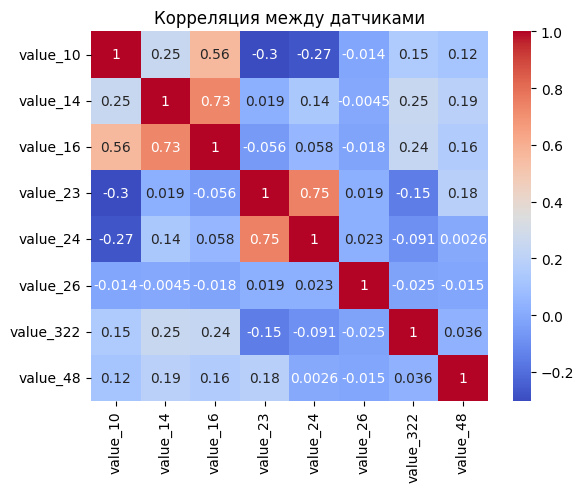

In [78]:
import seaborn as sns


sns.heatmap(correlation_matrix_1, annot=True, cmap="coolwarm")
plt.title("Корреляция между датчиками")
plt.show()